## Notebook to investigate Iterative Nullspace Projection for Amnesic Probing

### 1. Variance and cosine similarity of the representations after Iterative Nullspace Projection

In [35]:
import utils
import utils_amnesic_probing
import pickle
import torch
from collections import defaultdict

def get_representations(dataset, split, layer, amnesic_objective, N_projections, N_patches=None):
    """ input:
    N_projections (string) = ["all", "first", "each"]
    """
    threshold = 30 # ignore images with more than 30 object patches

    repr_path = f"../data/{dataset}/representations/{dataset}_{split}_visual.pickle"

    with open(repr_path, "rb") as f:
        repr = pickle.load(f)

    original = []

    if N_projections == "each":
        amnesic = defaultdict(lambda: [])
    else:
        amnesic = []

    file_name_patches = (
        f"../data/{dataset}/representations/{dataset}_{split}_patches.pickle"
    )

    with open(file_name_patches, "rb") as f:
        objectpatches = pickle.load(f)

    if N_projections == "all":
        P = utils_amnesic_probing.open_intersection_nullspaces(dataset, amnesic_objective, layer)
        P = torch.from_numpy(P)
    elif N_projections == "first":
        P = utils_amnesic_probing.open_first_rowspace_projection(dataset, amnesic_objective, layer)
        P = torch.from_numpy(P)
    elif N_projections == "each":
        path = f"../data/{dataset}/representations/rowspace_projections_{amnesic_objective}_layer{layer}.pickle"
        with open(path, "rb") as f:
            Ps = pickle.load(f)
        P_dict = {}
        for i in range(1, len(Ps)+1):
            P = utils_amnesic_probing.get_projection_to_intersection_of_nullspaces(Ps[:i], input_dim = 768)
            P = torch.from_numpy(P)
            P_dict[i] = P

    count = 0
    for img_id, repr in repr.items():
        
        patches = objectpatches[img_id]
        nodes = patches.keys()

        if len(nodes) <= threshold:
            input = utils.filter_repr(layer, nodes, repr, single_patch=True, padding_up_to=threshold)
            for i, patch_id in enumerate(nodes):
                patch = input[i]
                boxes = patches[patch_id]
                if len(boxes) > 1:
                    continue
                if N_patches is not None:
                    if count >= N_patches:
                        break
                    count += 1
                original.append(patch)
                if N_projections == "all" or N_projections == "first":
                    z = torch.from_numpy(patch)
                    z = torch.unsqueeze(z,0)
                    z = z.to(torch.float32)
                    P = P.to(torch.float32)
                    z = z @ P
                    amnesic_z = z.flatten()
                    amnesic.append(amnesic_z)
                elif N_projections == "each":
                    for j in range(1, len(Ps)+1):
                        P = P_dict[j]
                        # P = utils_amnesic_probing.get_projection_to_intersection_of_nullspaces(Ps[:i])
                        # P = torch.from_numpy(P)
                        z = torch.from_numpy(patch)
                        z = torch.unsqueeze(z,0)
                        z = z.to(torch.float32)
                        P = P.to(torch.float32)
                        z = z @ P
                        amnesic_z = z.flatten()
                        amnesic[len(original)-1].append(amnesic_z)

    print("count: ", count)
    return original, amnesic

# original_0, amnesic_0 = get_representations(dataset="pos", split="val", layer=0, amnesic_objective="shape", N_projections="all")

In [36]:
original_6, amnesic_6 = get_representations(dataset="pos", split="val", layer=6, amnesic_objective="shape", N_projections="each", N_patches=100)

count:  100


In [38]:
print(len(original_6))
print(original_6[0].size)
print(len(amnesic_6))
print(len(amnesic_6[0]))

100
768
100
71


In [42]:
type(amnesic_6)

collections.defaultdict

In [60]:
from numpy import dot
from numpy.linalg import norm
import collections
import numpy as np

def get_cos_sim(original, amnesic):
    if type(amnesic) == collections.defaultdict or type(amnesic) == dict:
        cos_sims = defaultdict(lambda: [])
        for i in range(len(original)):
            for j, proj_j in enumerate(amnesic[i]):
                cos_sim = dot(original[i], proj_j)/(norm(original[i])*norm(proj_j))
                cos_sims[j].append(cos_sim)
        for layer, cos_sim in cos_sims.items():
            cos_sims[layer] = np.mean(cos_sim), np.std(cos_sim)
        return dict(cos_sims)
    elif type(amnesic) == list:
        cos_sims = []
        for i in range(len(original)):
            cos_sim = dot(original[i], amnesic[i])/(norm(original[i])*norm(amnesic[i]))
            cos_sims.append(cos_sim)
        return np.mean(cos_sims), np.std(cos_sims)

cos_sims = get_cos_sim(original_6, amnesic_6)
print(cos_sims)

{0: (0.989896, 0.005602971), 1: (0.9813286, 0.008746027), 2: (0.9709736, 0.01142274), 3: (0.95268476, 0.014211025), 4: (0.94155455, 0.01668294), 5: (0.92387795, 0.018587986), 6: (0.89471596, 0.02069652), 7: (0.8634617, 0.025474723), 8: (0.8515704, 0.027254537), 9: (0.8457154, 0.028197702), 10: (0.8391916, 0.028394058), 11: (0.8311053, 0.028423483), 12: (0.82298476, 0.029518101), 13: (0.816585, 0.030823182), 14: (0.8125681, 0.030940637), 15: (0.80605805, 0.03125427), 16: (0.80043006, 0.031816334), 17: (0.7947105, 0.031676833), 18: (0.79016614, 0.03252039), 19: (0.78613454, 0.032904513), 20: (0.7822229, 0.032685224), 21: (0.7779938, 0.032557797), 22: (0.77373445, 0.032486603), 23: (0.76767784, 0.033098456), 24: (0.7623496, 0.03286527), 25: (0.75689924, 0.0336973), 26: (0.75010127, 0.033568207), 27: (0.7439459, 0.03404695), 28: (0.7383091, 0.033642765), 29: (0.7331464, 0.033454377), 30: (0.7279701, 0.034232814), 31: (0.7226792, 0.03385888), 32: (0.7161404, 0.033240966), 33: (0.71002585, 0

count:  100
count:  100
count:  100
count:  100
count:  100


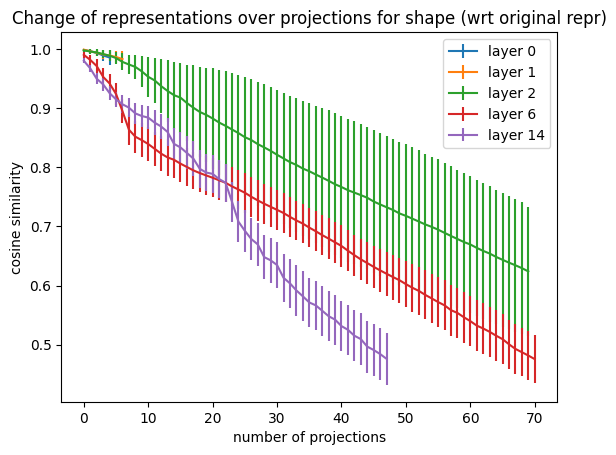

In [67]:
import matplotlib.pyplot as plt

def plot_cossims(layers: list, amnesic_objective, N_patches=100):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    for layer in layers:
        original, amnesic = get_representations(dataset="pos", split="val", layer=layer, amnesic_objective=amnesic_objective, N_projections="each", N_patches=N_patches)
        cos_sims = get_cos_sim(original, amnesic)

        x = [key for key in cos_sims.keys()]
        while len(x) < 72:
            x.append(np.nan)
        y = [mean for mean, std in cos_sims.values()]
        while len(y) < 72:
            y.append(np.nan)
        yerr = [std for mean, std in cos_sims.values()]
        while len(yerr) <72:
            yerr.append(np.nan)        
        ax.errorbar(x, y, yerr, label=f"layer {layer}")
    # plt.plot(cos_sims.keys(), cos_sims.values(), label="layer 6")
    plt.ylabel("cosine similarity")
    plt.xlabel("number of projections")
    plt.title(f"Change of representations over projections for {amnesic_objective} (wrt original repr)")
    ax.legend()
    plt.show()

plot_cossims(layers=[0,1,2,6,14], amnesic_objective="shape")

count:  100
count:  100
count:  100
count:  100
count:  100


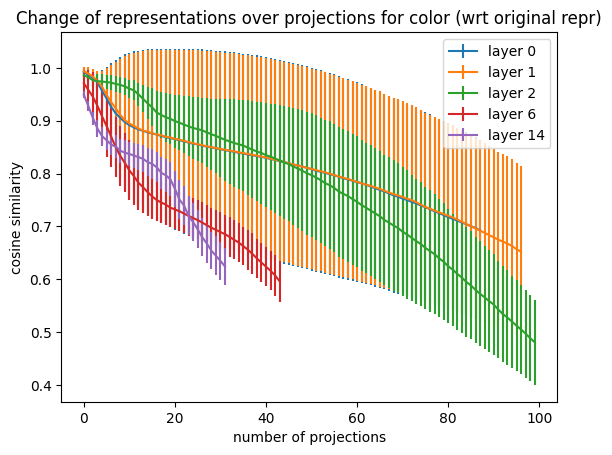

In [68]:
plot_cossims(layers=[0,1,2,6,14], amnesic_objective="color")

In [26]:
def get_all_cossim_layers(dataset, split, amnesic_objective, N_projections):
    results = {}
    for layer in range(15):
        original, amnesic = get_representations(dataset, split, layer, amnesic_objective, N_projections)
        cos_sim = get_cos_sim(original, amnesic)
        results[layer] = cos_sim
    return results

get_all_cossim_layers(dataset="pos", split="val", amnesic_objective="color", N_projections="all")

{0: 0.6540134303482517,
 1: 0.6181722042332096,
 2: 0.46607702039287346,
 3: 0.3532137670369134,
 4: 0.5308192574865813,
 5: 0.6070621602662924,
 6: 0.5968611360373617,
 7: 0.6511361465807045,
 8: 0.6381134049901309,
 9: 0.5628325855157522,
 10: 0.6531695814175631,
 11: 0.567289475565263,
 12: 0.5534526734808906,
 13: 0.6789319913711503,
 14: 0.6331713337538715}

In [27]:
get_all_cossim_layers(dataset="pos", split="val", amnesic_objective="shape", N_projections="all")

{0: 0.9845801022748422,
 1: 0.9815290306342299,
 2: 0.615261632648348,
 3: 0.553935966409016,
 4: 0.6638654228013813,
 5: 0.5629553082142473,
 6: 0.47345682809780526,
 7: 0.6002444857453831,
 8: 0.5640201843213273,
 9: 0.6133341747071079,
 10: 0.5481380929416609,
 11: 0.5219037188519913,
 12: 0.5815517434172245,
 13: 0.6136724187587846,
 14: 0.471739972804445}

## How many projections are needed per objective?

In [35]:
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
import style_package
# test()
plt.style.use("style_package.presentation")

In [3]:
import pickle

def open_intersection_nullspaces(dataset, objective, layer):
    path = f"../data/{dataset}/representations/"
    file_name = f"rowspace_projections_{objective}_layer{layer}.pickle"
    with open(path + file_name, "rb") as f:
        rowspace_projections = pickle.load(f)
    return len(rowspace_projections)

In [5]:

def get_dict_projections(objective):
    dict = {}
    for layer in range(15):
        dict[layer] = open_intersection_nullspaces("pos", objective, layer)
    return dict

projections_color = get_dict_projections("color")


In [6]:
projections_color

{0: 88,
 1: 97,
 2: 100,
 3: 82,
 4: 58,
 5: 46,
 6: 44,
 7: 32,
 8: 30,
 9: 41,
 10: 31,
 11: 39,
 12: 39,
 13: 26,
 14: 32}

In [7]:
projections_shape = get_dict_projections("shape")
projections_shape

{0: 5,
 1: 7,
 2: 70,
 3: 49,
 4: 41,
 5: 55,
 6: 71,
 7: 48,
 8: 49,
 9: 43,
 10: 54,
 11: 52,
 12: 44,
 13: 38,
 14: 48}

In [36]:
import numpy as np
import matplotlib.pyplot as plt

layer2name = {
    0: "embed",
    1: "pos",
    2: "ln_0",
    3: "1",
    4: "2",
    5: "3",
    6: "4",
    7: "5",
    8: "6",
    9: "7",
    10: "8",
    11: "9",
    12: "10",
    13: "11",
    14: "12",
    15: "ln_1",
    16: "output",
}

def make_plot(projections_color, projections_shape):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(projections_shape.keys(), projections_shape.values(), label="shape", linestyle="--", marker="o")    
    ax.plot(projections_color.keys(), projections_color.values(), label="color", linestyle="--", marker="o")
    plt.xticks(range(17), labels=layer2name.values(), rotation=45)
    plt.suptitle("Iterative nullspace projection")
    plt.legend()
    plt.ylabel("Number of projections")
    plt.xlabel("Layer")

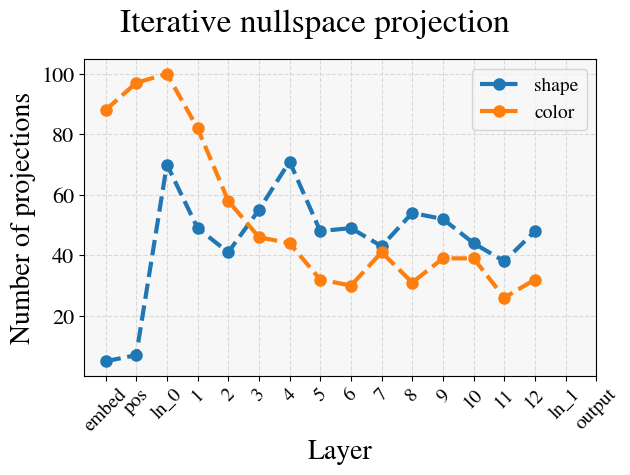

In [20]:
make_plot(projections_color, projections_shape)

## How well do the probes work?

In [90]:
results_color_file = "test_results_linear_layer_pos_color_unbalanced_filtered_{30}_single_patch_no_layernorm_amnesiccolor.pickle"
results_shape_file = "test_results_linear_layer_pos_shape_unbalanced_filtered_{30}_single_patch_no_layernorm_amnesicshape.pickle"

def open_results(filename):
    with open("../results/" + filename, "rb") as handle:
        y = pickle.load(handle)
    return y

results_color = open_results(results_color_file)
results_shape = open_results(results_shape_file)

In [44]:
results_shape

{0: [0.2914069890975952],
 1: [0.3017137944698334],
 2: [0.2724113166332245],
 3: [0.27696549892425537],
 4: [0.2843959629535675],
 5: [0.2716922461986542],
 6: [0.2724113166332245],
 7: [0.27582693099975586],
 8: [0.29721954464912415],
 9: [0.294043630361557],
 10: [0.27229148149490356],
 11: [0.29122722148895264],
 12: [0.3186720907688141],
 13: [0.31987056136131287],
 14: [0.3171740174293518]}

In [93]:
def make_plot(results_color, results_shape):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(results_shape.keys(), [value[0] for value in results_shape.values()], label="shape", linestyle="--", marker="o", color="blue")    
    ax.plot(results_color.keys(), [value[0] for value in results_color.values()], label="color", linestyle="--", marker="o", color="orange")
    plt.axhline(y=0.25, color="blue", linestyle="--")
    plt.axhline(y=0.2, color="orange", linestyle="--")
    # plt.ylim([0.15, 0.35])
    plt.ylim([0.15, 1.01])
    plt.xticks(range(17), labels=layer2name.values(), rotation=45)
    plt.suptitle("Linear probes on protected attribute")
    plt.legend()
    plt.ylabel("Accuracy")
    plt.xlabel("Layer")

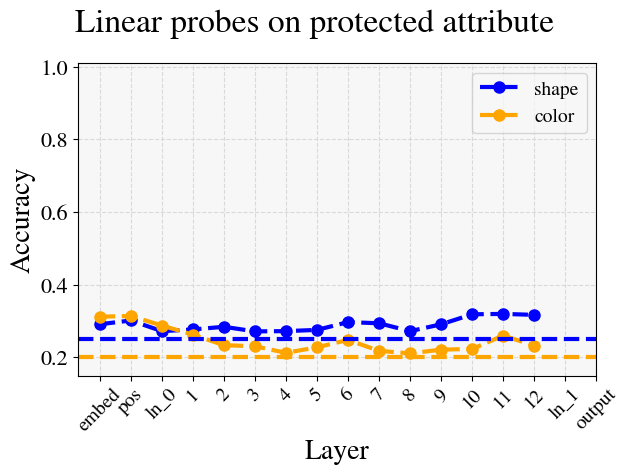

In [94]:
make_plot(results_color, results_shape)

In [95]:
results_color_file = "test_results_MLP2_pos_color_unbalanced_filtered_{30}_single_patch_no_layernorm_amnesiccolor.pickle"
results_shape_file = "test_results_MLP2_pos_shape_unbalanced_filtered_{30}_single_patch_no_layernorm_amnesicshape.pickle"

def open_results(filename):
    with open("../results/" + filename, "rb") as handle:
        y = pickle.load(handle)
    return y

results_color_MLP = open_results(results_color_file)
results_shape_MLP = open_results(results_shape_file)

In [96]:
def make_plot(results_color, results_shape):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(results_shape.keys(), [value[0] for value in results_shape.values()], label="shape", linestyle="--", marker="o", color="blue")    
    ax.plot(results_color.keys(), [value[0] for value in results_color.values()], label="color", linestyle="--", marker="o", color="orange")
    plt.axhline(y=0.25, color="blue", linestyle="--")
    plt.axhline(y=0.2, color="orange", linestyle="--")
    plt.ylim([0.15, 1.01])
    plt.xticks(range(17), labels=layer2name.values(), rotation=45)
    plt.suptitle("Non-linear probes on protected attribute")
    plt.legend()
    plt.ylabel("Accuracy")
    plt.xlabel("Layer")

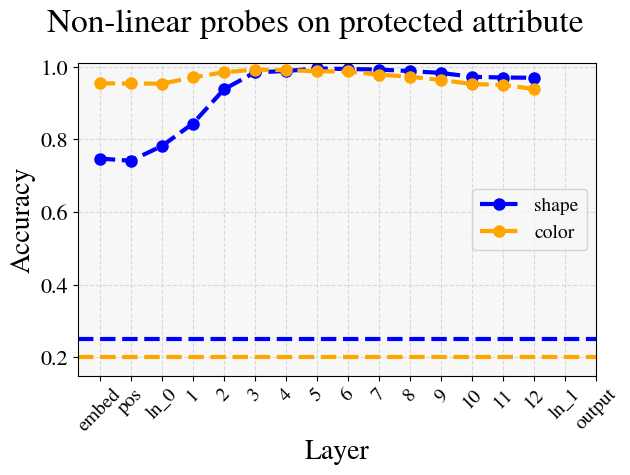

In [98]:
make_plot(results_color_MLP, results_shape_MLP)

## Binding problem with amnesic data

[{0: [0.8404124975204468, 0.8566684126853943, 0.8524733185768127, 0.8585911393165588, 0.8694283962249756], 1: [0.849327027797699, 0.8479287028312683, 0.8391889333724976, 0.8643593788146973, 0.831847608089447], 2: [0.8624366521835327, 0.8689040541648865, 0.8638349771499634, 0.8696032166481018, 0.8598147034645081], 3: [0.9292081594467163, 0.9334032535552979, 0.9349763989448547, 0.935151219367981, 0.9332284331321716], 4: [0.9414438009262085, 0.9360251426696777, 0.9379479289054871, 0.9410942196846008, 0.9417933821678162], 5: [0.9508827328681946, 0.9482607841491699, 0.9496591687202454, 0.9547281861305237, 0.9508827328681946], 6: [0.9557769894599915, 0.9545534253120422, 0.9529802203178406, 0.9503583312034607, 0.9514070749282837], 7: [0.9634678959846497, 0.9589232802391052, 0.9624191522598267, 0.9604964256286621, 0.9625939726829529], 8: [0.9596224427223206, 0.9596224427223206, 0.9564761519432068, 0.961020827293396, 0.9570005536079407], 9: [0.9559517502784729, 0.9582240581512451, 0.95420378446

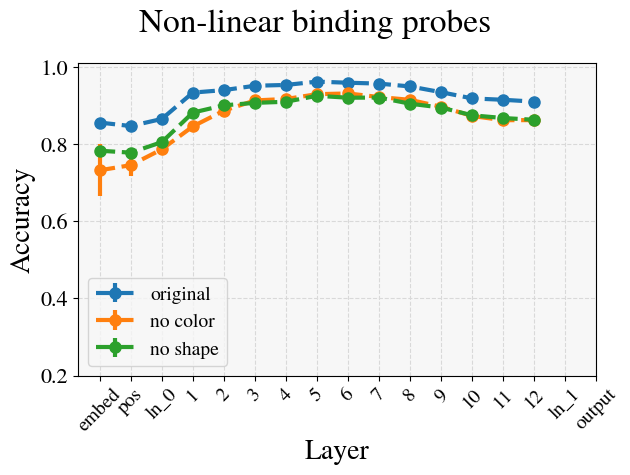

[{0: [0.8404124975204468,
   0.8566684126853943,
   0.8524733185768127,
   0.8585911393165588,
   0.8694283962249756],
  1: [0.849327027797699,
   0.8479287028312683,
   0.8391889333724976,
   0.8643593788146973,
   0.831847608089447],
  2: [0.8624366521835327,
   0.8689040541648865,
   0.8638349771499634,
   0.8696032166481018,
   0.8598147034645081],
  3: [0.9292081594467163,
   0.9334032535552979,
   0.9349763989448547,
   0.935151219367981,
   0.9332284331321716],
  4: [0.9414438009262085,
   0.9360251426696777,
   0.9379479289054871,
   0.9410942196846008,
   0.9417933821678162],
  5: [0.9508827328681946,
   0.9482607841491699,
   0.9496591687202454,
   0.9547281861305237,
   0.9508827328681946],
  6: [0.9557769894599915,
   0.9545534253120422,
   0.9529802203178406,
   0.9503583312034607,
   0.9514070749282837],
  7: [0.9634678959846497,
   0.9589232802391052,
   0.9624191522598267,
   0.9604964256286621,
   0.9625939726829529],
  8: [0.9596224427223206,
   0.9596224427223206,
  

In [81]:
import visualize_result

original_bp = "../results/test_results_MLP2_pos_binding_problem_unbalanced_filtered_{30}_no_layernorm.pickle"
amnesic_color = "../results/test_results_MLP2_pos_binding_problem_unbalanced_filtered_{30}_no_layernorm_amnesic{'color'}.pickle"
amnesic_shape = "../results/test_results_MLP2_pos_binding_problem_unbalanced_filtered_{30}_no_layernorm_amnesic{'shape'}.pickle"

config = {
    "no_plots": 3,
    "filenames": [original_bp, amnesic_color, amnesic_shape],
    "labels": ["original", "no color", "no shape"],
    "fig_title": "Non-linear binding probes",
    "save": True,
    "img_name": "binding_probes_amnesic.png",
    "only_transformer": False,
    "entire_y_axis": True,
    "counter": False,
}

visualize_result.plot_accuracy_probes(config)


[{0: [0.5739642381668091, 0.614703357219696, 0.6287112236022949, 0.56855309009552, 0.6382700204849243], 1: [0.6745740175247192, 0.5566271543502808, 0.6219229102134705, 0.5899891257286072, 0.5298611521720886], 2: [0.5237335562705994, 0.6502028703689575, 0.6958338022232056, 0.6294391751289368, 0.7068601846694946], 3: [0.6867850422859192, 0.6760322451591492, 0.650339663028717, 0.6407414078712463, 0.6688776612281799], 4: [0.6353487968444824, 0.6497669816017151, 0.6694665551185608, 0.6548744440078735, 0.6599239706993103], 5: [0.6731806397438049, 0.6526325345039368, 0.6634363532066345, 0.688781201839447, 0.6955463290214539], 6: [0.724565863609314, 0.6775021553039551, 0.7227320075035095, 0.6818190217018127, 0.6903924942016602], 7: [0.7115340828895569, 0.6542670130729675, 0.6714070439338684, 0.6968423128128052, 0.6485869288444519], 8: [0.661328911781311, 0.6575754284858704, 0.6770315170288086, 0.6648806929588318, 0.6633065342903137], 9: [0.6978508234024048, 0.7345373630523682, 0.60838800668716

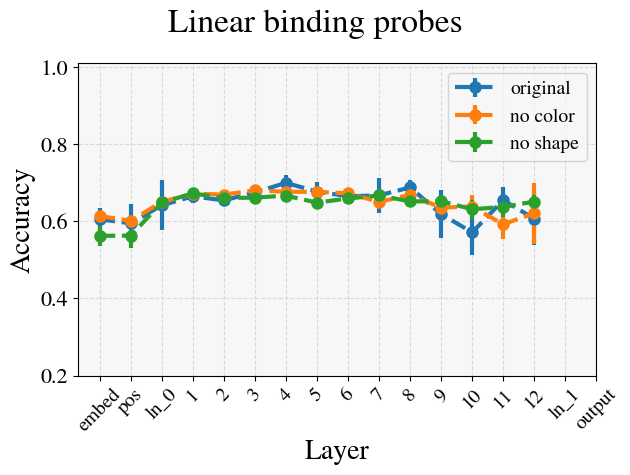

[{0: [0.5739642381668091,
   0.614703357219696,
   0.6287112236022949,
   0.56855309009552,
   0.6382700204849243],
  1: [0.6745740175247192,
   0.5566271543502808,
   0.6219229102134705,
   0.5899891257286072,
   0.5298611521720886],
  2: [0.5237335562705994,
   0.6502028703689575,
   0.6958338022232056,
   0.6294391751289368,
   0.7068601846694946],
  3: [0.6867850422859192,
   0.6760322451591492,
   0.650339663028717,
   0.6407414078712463,
   0.6688776612281799],
  4: [0.6353487968444824,
   0.6497669816017151,
   0.6694665551185608,
   0.6548744440078735,
   0.6599239706993103],
  5: [0.6731806397438049,
   0.6526325345039368,
   0.6634363532066345,
   0.688781201839447,
   0.6955463290214539],
  6: [0.724565863609314,
   0.6775021553039551,
   0.7227320075035095,
   0.6818190217018127,
   0.6903924942016602],
  7: [0.7115340828895569,
   0.6542670130729675,
   0.6714070439338684,
   0.6968423128128052,
   0.6485869288444519],
  8: [0.661328911781311,
   0.6575754284858704,
   0.6

In [83]:
original_bp = "../results/test_results_linear_layer_pos_binding_problem_unbalanced_filtered_{30}_no_layernorm.pickle"
amnesic_color = "../results/test_results_linear_layer_pos_binding_problem_unbalanced_filtered_{30}_no_layernorm_amnesic{'color'}.pickle"
amnesic_shape = "../results/test_results_linear_layer_pos_binding_problem_unbalanced_filtered_{30}_no_layernorm_amnesic{'shape'}.pickle"

config = {
    "no_plots": 3,
    "filenames": [original_bp, amnesic_color, amnesic_shape],
    "labels": ["original", "no color", "no shape"],
    "fig_title": "Linear binding probes",
    "save": True,
    "img_name": "linear_binding_probes_amnesic.png",
    "only_transformer": False,
    "entire_y_axis": True,
    "counter": False,
}

visualize_result.plot_accuracy_probes(config)


Are linear probes actually better than a random probe on the binding problem?
Construct a random probe that randomly outputs 0 or 1 for any combination of patches.

In [1]:
import utils

layer = 0

loader_test = utils.build_dataloader_twopatches(
    dataset="pos",
    layer = layer,
    split= "test",
    threshold = 30,
    amnesic_obj=None,
    first_projection_only=None,
    mode="normal",
)

Will try to open representations of pos of split test
majority label of 1 for split test:  0.176132421449103
len dataset:  413649


In [2]:
import random

def use_random_model():
    return random.choice([0,1])

In [5]:
results = []

for xs, ys in loader_test:
    for y in ys:
        pred = use_random_model()
        if y == pred:
            results.append(1)
        else:
            results.append(0)

acc = sum(results)/len(results)
print(acc)

0.5008231616660502


## Compare iterative nullspace projection with different data

In [28]:
import pickle
import numpy as np

layer2name = {
    0: "embed",
    1: "pos",
    2: "ln_0",
    3: "1",
    4: "2",
    5: "3",
    6: "4",
    7: "5",
    8: "6",
    9: "7",
    10: "8",
    11: "9",
    12: "10",
    13: "11",
    14: "12",
    15: "ln_1",
    16: "output",
}

def plot_accuracy_probes(config):
    """input:
    config (dict): contains the keys, "filenames", "labels", "fig_title", "save", "only_transformer",
    """
    results = []
    xs = []
    ys = []
    yerrors = []
    N_probes = len(config["filenames"])
    fig_title = config["fig_title"]

    for name in config["filenames"]:
        with open(name, "rb") as handle:
            y = pickle.load(handle)
        results.append(y)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    for result in results:
        x = [int(key) for key in result.keys()]
        while len(x) < 17:
            x.append(np.nan)
        y = [
            np.mean(result[key]) if result[key] is not np.nan else np.nan
            for key in result.keys()
        ]
        while len(y) < 17:
            y.append(np.nan)
        yerr = [
            np.std(result[key]) if result[key] is not np.nan else np.nan
            for key in result.keys()
        ]
        while len(yerr) < 17:
            yerr.append(np.nan)
        xs.append(x)
        ys.append(y)
        yerrors.append(yerr)

    color = ["blue", "orange", "orange", "g", "g"]
    linestyle = ["dashed", "dashed", "dotted", "dashed", "dotted"]
    for i in range(N_probes):
        ax.errorbar(
            xs[i],
            ys[i],
            yerrors[i],
            linestyle=linestyle[i],
            # marker=marker[i],
            marker="o",
            label=config["labels"][i],
            color=color[i],
        )
    plt.xticks(range(17), labels=layer2name.values(), rotation=45)
    plt.suptitle(fig_title)
    plt.legend()

    plt.ylabel("Accuracy")
    plt.xlabel("Layer")

    if config["entire_y_axis"]:
        plt.ylim([0.2, 1.01])

    if config["save"]:
        if config["img_name"] is not None:
            imgname = "../plots/" + config["img_name"]
            plt.savefig(imgname, bbox_inches="tight")

    plt.show()

    return

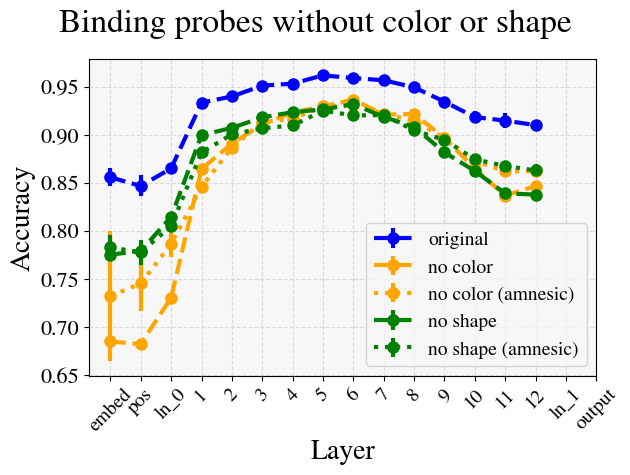

In [30]:
original_bp = "../results/test_results_MLP2_pos_binding_problem_unbalanced_filtered_{30}_no_layernorm.pickle"
amnesic_color = "../results/test_results_MLP2_trainedonpos_testedonposmo_binding_problem_filtered_{30}_no_layernorm_mode{args.mode}.pickle"
amnesic_shape = "../results/test_results_MLP2_trainedonpos_testedonsup1_binding_problem_filtered_{30}_no_layernorm_mode{args.mode}.pickle"
amnesic_color_amnesic = "../results/test_results_MLP2_pos_binding_problem_unbalanced_filtered_{30}_no_layernorm_amnesic{'color'}.pickle"
amnesic_shape_amnesic = "../results/test_results_MLP2_pos_binding_problem_unbalanced_filtered_{30}_no_layernorm_amnesic{'shape'}.pickle"


config = {
    "no_plots": 5,
    "filenames": [original_bp, amnesic_color, amnesic_color_amnesic, amnesic_shape, amnesic_shape_amnesic],
    "labels": ["original", "no color", "no color (amnesic)", "no shape", "no shape (amnesic)"],
    "fig_title": "Binding probes without color or shape",
    "save": True,
    "img_name": "binding_probes_amnesic_diffdata.png",
    "only_transformer": False,
    "entire_y_axis": False,
    "counter": False,
}

plot_accuracy_probes(config)

## Plot the accuracies of kernelized concept erasure

First, polynomial.

In [64]:
file_path = "../../../../../../../Volumes/Seagate Expansion Drive/numerosity_thesis/kernel_removal/poly/pos/"
file_path_sub_kernelspace = "kernel-type=poly_d=1024_gamma=0.1_degree=2_alpha=1/preimage/Z_test.kernel-type=poly_d=1024_gamma=0.1_degree=2_alpha=1.pickle"

In [65]:
import pickle
import os

def get_scores_kernelspace(objective):
    accuracies = {}
    for subdir in os.listdir(file_path + f"{objective}/"):
        layer = subdir.replace("layer", "")
        with open(file_path + f"{objective}/" + subdir + "/" + file_path_sub_kernelspace, "rb") as f:
            _, _, _, acc = pickle.load(f)
        accuracies[int(layer)] = acc

    return accuracies

In [67]:
accuracies_color_kernelspace = get_scores_kernelspace("color")
accuracies_shape_kernelspace = get_scores_kernelspace("shape")

print("color: \n", accuracies_color_kernelspace)
print("shape: \n", accuracies_shape_kernelspace)

color: 
 {0: 0.8775, 1: 0.8845, 11: 0.93346, 13: 0.91958, 2: 0.86864, 3: 0.93428, 4: 0.93728, 5: 0.94398, 7: 0.9612, 9: 0.96804}
shape: 
 {0: 0.29332, 1: 0.29356, 10: 0.95094, 11: 0.91722, 12: 0.92726, 13: 0.92328, 14: 0.87144, 2: 0.30198, 3: 0.42596, 4: 0.51944, 5: 0.6201, 6: 0.7874, 7: 0.86698, 8: 0.9387, 9: 0.94108}


(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)


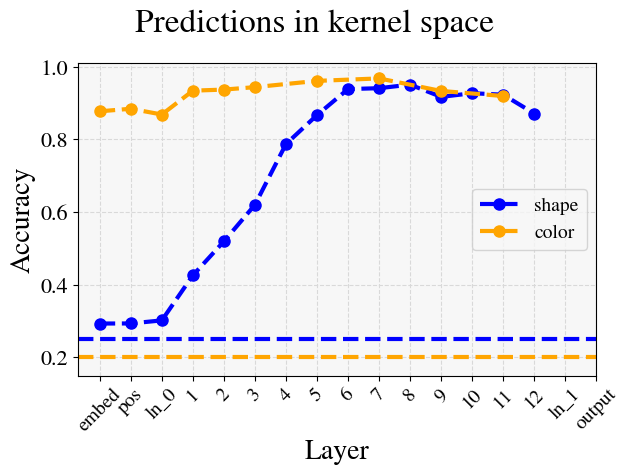

In [70]:
import matplotlib.pyplot as plt

def make_plot(results_color, results_shape, figtitle):
    results_color = sorted(results_color.items())
    x_color, y_color = zip(*results_color)
    results_shape = sorted(results_shape.items())
    x_shape, y_shape = zip(*results_shape)
    print(x_shape)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x_shape, y_shape, label="shape", linestyle="--", marker="o", color="blue")    
    ax.plot(x_color, y_color, label="color", linestyle="--", marker="o", color="orange")
    plt.axhline(y=0.25, color="blue", linestyle="--")
    plt.axhline(y=0.2, color="orange", linestyle="--")
    plt.ylim([0.15, 1.01])
    plt.xticks(range(17), labels=layer2name.values(), rotation=45)
    plt.suptitle(figtitle)
    plt.legend()
    plt.ylabel("Accuracy")
    plt.xlabel("Layer")

make_plot(accuracies_color_kernelspace, accuracies_shape_kernelspace, "Predictions in kernel space")

In [47]:
import pickle
import os

file_path_sub = "kernel-type=poly_d=1024_gamma=0.1_degree=2_alpha=1/preimage/eval/scores_with_multiple2.pickle"

def get_scores_eval(objective):
    accuracies = {}
    for subdir in os.listdir(file_path + f"{objective}/"):
        layer = subdir.replace("layer", "")
        if os.path.exists(file_path + f"{objective}/" + subdir + "/" + file_path_sub):
            with open(file_path + f"{objective}/" + subdir + "/" + file_path_sub, "rb") as f:
                acc = pickle.load(f)
            accuracies[int(layer)] = list(acc.values())[0]

    return accuracies

accuracies_eval_color = get_scores_eval("color")
accuracies_eval_shape = get_scores_eval("shape")

print("color: \n", accuracies_eval_color)
print("shape: \n", accuracies_eval_shape)

color: 
 {0: 0.924485707029376, 1: 0.9221435223071931, 11: 0.9678302339362813, 13: 0.9586590286988176, 2: 0.9273640545192877, 3: 0.9326128058244209, 4: 0.9409656573637724, 5: 0.9503908344385812, 7: 0.9703417332166944, 9: 0.977481163755397}
shape: 
 {0: 0.37695064480627594, 10: 0.9788921184073144, 12: 0.9635691508874905, 14: 0.9196884612128566, 2: 0.37723283573665944, 4: 0.7553122442644693, 6: 0.8960972994327963, 8: 0.9757880181730959}


(0, 2, 4, 6, 8, 10, 12, 14)


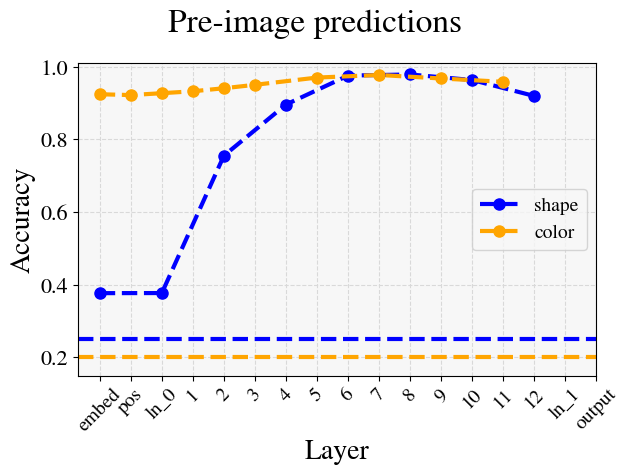

In [71]:
import matplotlib.pyplot as plt

# def make_plot(results_color, results_shape):
#     results_color = sorted(results_color.items())
#     x_color, y_color = zip(*results_color)
#     results_shape = sorted(results_shape.items())
#     x_shape, y_shape = zip(*results_shape)
#     print(x_shape)
#     fig = plt.figure()
#     ax = fig.add_subplot(1, 1, 1)
#     ax.plot(x_shape, y_shape, label="shape", linestyle="--", marker="o", color="blue")    
#     ax.plot(x_color, y_color, label="color", linestyle="--", marker="o", color="orange")
#     plt.axhline(y=0.25, color="blue", linestyle="--")
#     plt.axhline(y=0.2, color="orange", linestyle="--")
#     plt.ylim([0.15, 1.01])
#     plt.xticks(range(17), labels=layer2name.values(), rotation=45)
#     plt.suptitle("Prediction accuracy with poly kernel")
#     plt.legend()
#     plt.ylabel("Accuracy")
#     plt.xlabel("Layer")

make_plot(accuracies_eval_color, accuracies_eval_shape, "Pre-image predictions")

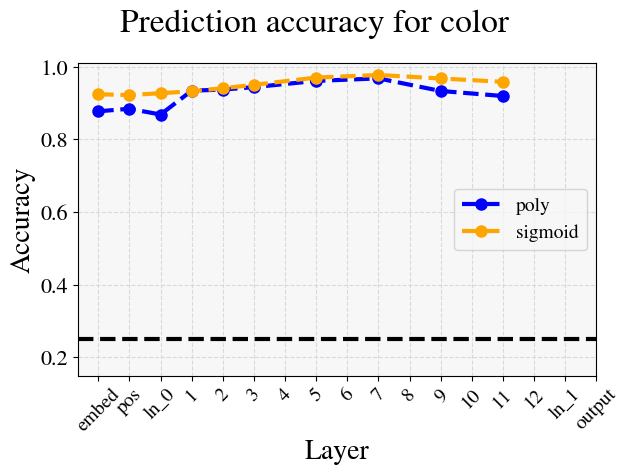

In [57]:
make_plot(accuracies_color, accuracies_eval_color)

Now, sigmoid (only color).

In [ ]:
file_path_sub = "kernel-type=sigmoid_d=1024_gamma=0.005_degree=None_alpha=0/preimage/Z_test.kernel-type=sigmoid_d=1024_gamma=0.005_degree=None_alpha=0.pickle"

def get_scores():
    accuracies = {}
    for subdir in os.listdir():
        layer = subdir.replace("layer", "")
        if os.path.exists(subdir + "/" + file_path_sub):
            with open(subdir + "/" + file_path_sub, "rb") as f:
                _, _, _, acc = pickle.load(f)
            accuracies[int(layer)] = acc
    return accuracies

Output: {5: 0.77912, 4: 0.8515, 0: 0.54504, 2: 0.706, 9: 0.91088}

In [ ]:
file_path_sub = "kernel-type=sigmoid_d=1024_gamma=0.005_degree=None_alpha=0/preimage/eval/scores_with_multiple2.pickle"

def get_scores():
    accuracies = {}
    for subdir in os.listdir():
        layer = subdir.replace("layer", "")
        if os.path.exists(subdir + "/" + file_path_sub):
            with open(subdir + "/" + file_path_sub, "rb") as f:
                acc = pickle.load(f)
            accuracies[int(layer)] = acc
    return accuracies

Output: {5: {'kernel-type=sigmoid_d=1024_gamma=0.005_degree=None_alpha=0_adv-type=sigmoid': 0.90253125264554}, 11: {}, 13: {}, 4: {'kernel-type=sigmoid_d=1024_gamma=0.005_degree=None_alpha=0_adv-type=sigmoid': 0.8851765104269549}, 3: {}, 0: {'kernel-type=sigmoid_d=1024_gamma=0.005_degree=None_alpha=0_adv-type=sigmoid': 0.5527273753421565}, 7: {}, 2: {'kernel-type=sigmoid_d=1024_gamma=0.005_degree=None_alpha=0_adv-type=sigmoid': 0.8368372040522618}, 9: {'kernel-type=sigmoid_d=1024_gamma=0.005_degree=None_alpha=0_adv-type=sigmoid': 0.9351807432909106}, 1: {}}

{5: 0.90253125264554, 4: 0.8851765104269549, 0: 0.5527273753421565, 2: 0.8368372040522618, 9: 0.9351807432909106}

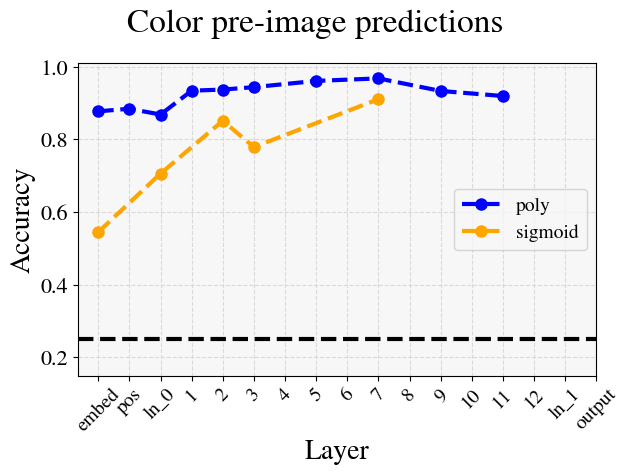

In [77]:
color_sigmoid = {5: 0.77912, 4: 0.8515, 0: 0.54504, 2: 0.706, 9: 0.91088}

def make_plot(color_poly, color_sigmoid, figtitle):
    color_poly = sorted(color_poly.items())
    x_poly, y_poly = zip(*color_poly)
    color_sigmoid = sorted(color_sigmoid.items())
    x_sigmoid, y_sigmoid = zip(*color_sigmoid)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x_poly, y_poly, label="poly", linestyle="--", marker="o", color="blue")    
    ax.plot(x_sigmoid, y_sigmoid, label="sigmoid", linestyle="--", marker="o", color="orange")
    plt.axhline(y=0.25, color="black", linestyle="--")
    plt.ylim([0.15, 1.01])
    plt.xticks(range(17), labels=layer2name.values(), rotation=45)
    plt.suptitle(figtitle)
    plt.legend()
    plt.ylabel("Accuracy")
    plt.xlabel("Layer")

make_plot(accuracies_color_kernelspace, color_sigmoid, "Color pre-image predictions")

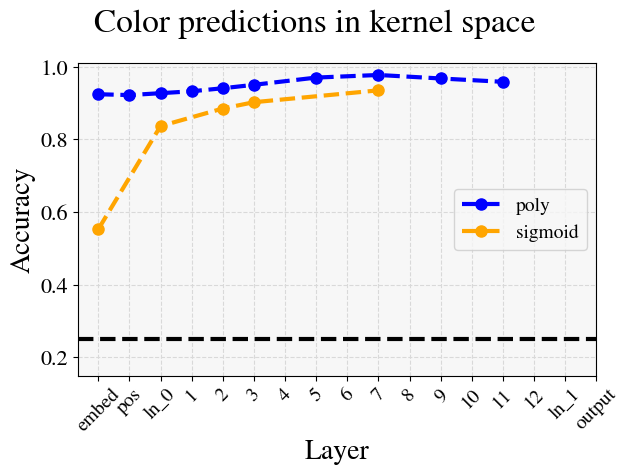

In [76]:
color_sigmoid_eval = {5: 0.90253125264554, 4: 0.8851765104269549, 0: 0.5527273753421565, 2: 0.8368372040522618, 9: 0.9351807432909106}

make_plot(accuracies_eval_color, color_sigmoid_eval, "Color predictions in kernel space")